# Day 22: Mode Maze

## Part 1

The two function `geoidx` and `erosion` implement a level of cross-recursion that can become very deep, better implement some memoization!

In [17]:
import numpy as np
from collections import defaultdict

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

def geoidx(x,y,depth,xt=10,yt=10):
    if G[(x,y)]!= -1:
        return G[(x,y)]
    g = -1
    if x==xt and y==yt:
        g = 0
        G[(x,y)] = g
        return g
    if y==0:
        g = x*16807
        G[(x,y)] = g
        return g
    if x==0:
        g = y*48271
        G[(x,y)] = g
        return g
    else:
        g = erosion(x-1,y,depth,xt,yt)*erosion(x,y-1,depth,xt,yt)
        G[(x,y)] = g
        return g

def erosion(x,y,depth,xt=10,yt=10):
    if E[(x,y)]!= -1:
        return E[(x,y)] 
    e = ( geoidx(x,y,depth,xt,yt) + depth )%20183
    E[(x,y)] = e
    return e

def cavetype(x,y,depth=510,xt=10,yt=10):
    if C[(x,y)]!=-1:
        return C[(x,y)]
    c = erosion(x,y,depth,xt,yt) % 3
    C[(x,y)] = c
    return c

def exploreCave(depth=510,xt=10,yt=10):
    cave = np.zeros((yt+1,xt+1),dtype=int)
    for y in range(yt+1):
        for x in range(xt+1):
            cave[y][x] = cavetype(x,y,depth,xt,yt)
    return cave

Risk level = 114


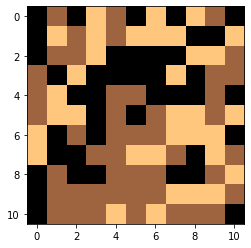

In [18]:
# Re-initialize cache dictionaries to avoid contamination between example and full input

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)
    
cave = exploreCave(depth=510,xt=10,yt=10)

import matplotlib.pyplot as plt
plt.imshow(cave,cmap="copper")
print("Risk level =",sum(sum(cave)))

In [238]:
depth = 10689
xt = 11
yt = 722

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

cave = exploreCave(depth,xt,yt)

print("Risk level =",sum(sum(cave)))

#plt.figure(figsize=(10,100),dpi=100)
#plt.imshow(cave,cmap="copper")

Risk level = 8575


## Part 2

This could probably be solved with BFS tracking all possible paths of (positions on grid, equipement status) pairs, where possible next steps depend on adjacent cave values and previous equipemnt status.

On the other hand, there's no guarantee that the best path would be in the minimal rectangle needed to solve Part 1, so I should probably generate a larger cave. I can maybe avoid doing this beforehand by also caching the already-computed cave type in a `defaultdict`, and let the recursion compute and store whethevent is needed on the fly.

* Adding `cavetype` function and `C` dictionary to Part 1

BFS itself is probably not enough since moving have different "cost" (e.g. time) depeding on whether I need to swicth equipement. Maybe I can introduce a priority queue sorting path by shorter time up to current position?

* Using `PriorityQueue` with time as index

Ok, I can solve the example! 

To speedup things I now only save the last (position,equipment) and not the full path.

Still failing with the full input... :-(

In [239]:
def getAdiacent(s):
    x,y = s
    return [ (x+i,y+j) for i in (+1,0,-1) for j in (+1,0,-1) if x+i>=0 and y+j>=0 and i!=j and abs(i+j)==1 and (x+i,y+j)!=s  ]

#getAdiacent((0,0))
getAdiacent((1, 1))

[(2, 1), (1, 2), (1, 0), (0, 1)]

In [233]:
ROCKY  = 0 # CLIMB or TORCH : 1, 2
WET    = 1 # CLIMB or NONE  : 2, 0
NARROW = 2 # TORCH or NONE  : 1, 0

NONE  = 0
TORCH = 1
CLIMB = 2

def validEquipIfs(cavetype,equip):
    if cavetype==ROCKY and ( equip==CLIMB or equip==TORCH ):
        return True
    elif cavetype==WET and ( equip==CLIMB or equip==NONE ):
        return True
    elif cavetype==NARROW and ( equip==TORCH or equip==NONE ):
        return True
    else:
        return False

def validEquip(cavetype,equip):
    return cavetype != equip

ct = NARROW
eq = TORCH
validEquipIfs(ct,eq), validEquip(ct,eq)

(True, True)

In [251]:
# 0: 1,2
# 1: 0,2
# 2: 1,0

#def alterEquip(equip):
#    eqList = [ NONE, TORCH, CLIMB ]
#    eqList.pop( eqList.index(equip) )
#    return eqList

def alterEquip(equip):
    if equip==NONE:
        return [ TORCH, CLIMB ]
    elif equip==TORCH:
        return [ NONE, CLIMB ]
    elif equip==CLIMB:
        return [ NONE, TORCH ]

alterEquip(CLIMB)

[0, 1]

In [252]:
from queue import PriorityQueue
from copy import deepcopy
        
def getShortedPath(depth = 510, xt = 10, yt = 10):
    
    start = (0,0)
    end = (xt,yt)

    s = (start,TORCH)
    e = (end,TORCH)

    visited = defaultdict(bool)
    visited[s] = True

    q = PriorityQueue()
    q.put((0,s)) # time, (last position in path,last equipment)

    steps = 0
    
    while True:
        
        t,pe = q.get()

        if pe==e:
            print("Reached target at",end,"in t =", t, end=". ")
            print("Steps =",steps)
            return

        p,eq = pe        
        xp,yp = p    
        ctp = cavetype(xp,yp,depth,xt,yt)
        
        for a in getAdiacent(p):

            xa,ya = a
            cta = cavetype(xa,ya,depth,xt,yt)

            # current equipement is valid for next step
            if validEquip(cta,eq): 
                ns = (a,eq)
                if not visited[ns]:
                    q.put((t+1,ns))
                    visited[ns] = True

            # also try to change equipement staying on same place, 
            # since it might lead to better path later despite loss in time now 
            for alteq in alterEquip(eq):
                if validEquip(ctp,alteq):
                    ns = (p,alteq)
                    if not visited[ns]:
                        q.put((t+7,ns))
                        visited[ns] = True
            
        steps += 1

Reached target at (10, 10) in t = 45. Steps = 495


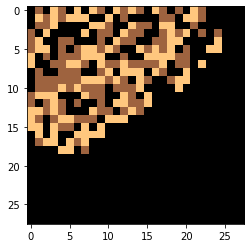

In [253]:
# Example: fastest way to reach the target: 45 minutes. 

G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

getShortedPath(depth=510,xt=10,yt=10)

cave = np.zeros((28,28),dtype=int)
for x,y in C.keys():
    cave[y][x] = C[(x,y)]
    
plt.imshow(cave,cmap="copper")

In [254]:
G = defaultdict(lambda: -1)
E = defaultdict(lambda: -1)
C = defaultdict(lambda: -1)

getShortedPath(depth=10689,xt=11,yt=722)

Reached target at (11, 722) in t = 1012. Steps = 798876


In [219]:
# 1012 too high

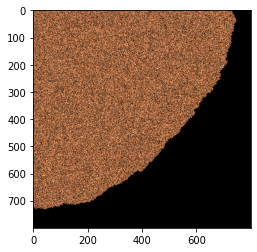

In [250]:
cave = np.zeros((800,800),dtype=int)
for x,y in C.keys():
    cave[y][x] = C[(x,y)]
    
plt.imshow(cave,cmap="copper")